In [1]:
import numpy as np
from scipy.stats import norm, qmc
import matplotlib.pyplot as plot
import torch
import torch.nn as nn
import pandas as pd
import yfinance as yf

## Data Generation using Analytical Black scholes

Generate synthetic training data using realistic distributions that reflect the real market characteristics while maininting the braod surface coverage. We are using Sobol for the data generation process for uniformity and spacefilling 

Domain for data generation:
- $x=(ln(S/K),T,r,\sigma)$, 
- $ln(S/K) \in [-1.5, 1.5]$, 
- $T \in [0.01, 2.0]$ in years, 
- $r \in [0.04]$ fixed, can vary later, 
- $\sigma\in[0.05,0.90].$ 

## Data Sampling

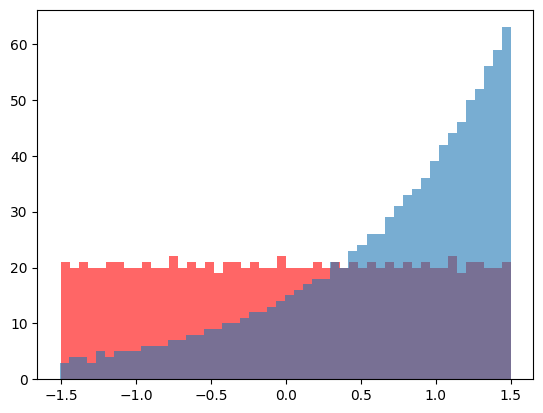

In [35]:
sampler = qmc.Sobol(d=1, scramble=True, seed=42)
sample = sampler.random_base2(m=10)
log_sk = qmc.scale(sample, -1.5, 1.5)
sk = qmc.scale(sample, 0.22, 4.48) 
sk = np.log(sk)
plot.hist(log_sk, bins=50, alpha=0.6, color='red')
plot.hist(sk, bins=50, alpha=0.6)
plot.show()

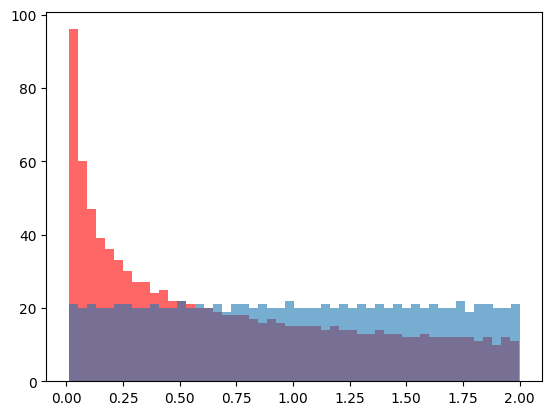

In [36]:
sampler = qmc.Sobol(d=1, scramble=True, seed=42)
sample = sampler.random_base2(m=10)
l_roott = np.sqrt(0.01)
u_roott = np.sqrt(2)
troot = qmc.scale(sample, l_roott, u_roott)
t = qmc.scale(sample, 0.01, 2)
T = troot**2
plot.hist(T, bins=50, alpha=0.6, color='red')
plot.hist(t, bins=50, alpha=0.6)
plot.show()

## Blacksholes Implementation 

In [37]:
# blackscholes implementation 
class BlackScholesPricer: 
    def __init__(self, r: float):
        self.r = r                                            # since r is a model parameter we initialize this seperately      

    def price(self, S, K, T, sigma, option_type='C'):
        """
        Calculates the blackscholes option price for call and put options 
        Args:
            S (float): Stock price       
            K (float): Strike price                
            T (float): Time to maturity in years 
            r (float): risk free rate 
            sigma (float): volatility of the underlying 
        Returns:
            option price (float)
        Raises:
            ValueError: if sigma < 0 and T <= 0 
        """
        # input casting and vectorize
        S, K, T, sigma = map(np.asarray, (S, K, T, sigma))
        
        # Input validation 
        if np.any(sigma < 0):
            raise ValueError("Volatility cannot be negative")
        if np.any(T <= 0):
            raise ValueError("Expiry must be > 0")
        
        # black scholes variables 
        sqrt_T = np.sqrt(T)
        d1 = (np.log(S / K) + (self.r + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        
        # dic factor
        disc = np.exp(-self.r * T)
        
        # black scholes pricing formula 
        if option_type == 'C':
            price = S * norm.cdf(d1) - K * disc * norm.cdf(d2) 
        elif option_type == 'P':
            price = K * disc * norm.cdf(-d2) - S * norm.cdf(-d1) 
        else:
            raise ValueError(f"option type must be 'C' or 'P got '{option_type}'")
            
        return price

#### Homogenity

In [38]:
# since the blacksholes is homogenous of degree one we can price options in the unit of K 
class LogMoneynessPricer:
    
    def __init__(self, bs_pricer: BlackScholesPricer):
        self.bs_pricer = bs_pricer
        
    def price(self, M, T, sigma, option_type='C'):
        M, T, sigma = map(np.asarray, (M, T, sigma))
        
        K = 1.0 # price in units of K 
        S = np.exp(M) * K 
        
        C = self.bs_pricer.price(S, K, T, sigma, option_type)
        return C / K 

#### Data generator

In [39]:
# dataGenerator.py
# Sobol sampler 
class SobolSampler:
    def __init__(self, l_bounds, u_bounds, seed=42):
        self.l_bounds = l_bounds 
        self.u_bounds = u_bounds
        self.sampler = qmc.Sobol(d=3, scramble=True, seed=seed)
        
    def sample(self, m):
        unit_cube = self.sampler.random_base2(m=m)
        return qmc.scale(unit_cube, self.l_bounds, self.u_bounds)

# Data generator 
class BSDataGenerator:
    def __init__(self, sampler: SobolSampler, pricer: LogMoneynessPricer):
        self.sampler = sampler 
        self.pricer = pricer 
    
    def generate(self, m, option_type='C'):
        sample = self.sampler.sample(m)
        
        M, sqrt_T, sigma = sample.T 
        T = sqrt_T**2 
        
        X = np.column_stack([M, T, sigma])
        y = self.pricer.price(M, T, sigma, option_type)
        return X, y 

#### Sampling 

In [40]:
bs = BlackScholesPricer(r=0.04)
l_bounds = [-1.5, np.sqrt(0.01), 0.05]
u_bounds = [1.5, np.sqrt(2), 0.60]
sample = SobolSampler(l_bounds, u_bounds)
logm_pricer = LogMoneynessPricer(bs)

gen = BSDataGenerator(sample, logm_pricer)
X, y = gen.generate(m=14)

In [41]:
feature = torch.tensor(X, dtype=torch.float32)
target = torch.tensor(y, dtype=torch.float32)
print(feature.shape)
print(target.shape)

torch.Size([16384, 3])
torch.Size([16384])


In [42]:
print(feature.dtype)


torch.float32


### Training Baseline Model 

In [43]:
# layer 1
torch.manual_seed(42)
layer1 = nn.Linear(in_features=3, out_features=64)
output1 = layer1(feature)                       
a = nn.ELU()                     # elu activation
l1 = a(output1)
print(f"layer 1: {l1.shape}")

# layer 2 
layer2 = nn.Linear(in_features=64, out_features=64)
output2 = layer2(l1)                       
a = nn.ELU()                     # elu activation
l2 = a(output2)
print(f"layer 2: {l2.shape}")

# layer 3 
layer3 = nn.Linear(in_features=64, out_features=1)
output3 = layer3(l2)             # no activation at output layer
print(f"layer 3: {output3.shape}")

# mse loss calculation mse 
output3 = output3.squeeze()
output3.shape
mse = 1/len(output3)*(sum((output3 - target)**2))
print(f"Manual MSE: {mse}") 

# mse 
loss_fn = nn.MSELoss()
mse = loss_fn(output3, target)
print(f"NN.MSE: {mse}")

# parameter 
list(layer1.parameters())
for p in layer1.parameters():
    print(p.shape)
all_params = list(layer1.parameters()) + list(layer2.parameters()) + list(layer3.parameters())
len(all_params)

# optimizer
optimizer = torch.optim.Adam(all_params, lr=0.001)
optimizer.zero_grad()                   # clear the old gradients 
mse.backward()
optimizer.step()

layer 1: torch.Size([16384, 64])
layer 2: torch.Size([16384, 64])
layer 3: torch.Size([16384, 1])
Manual MSE: 1.4851263761520386
NN.MSE: 1.4851336479187012
torch.Size([64, 3])
torch.Size([64])


In [ ]:
# Forward pass 2
output1 = layer1(feature)
l1 = a(output1)
output2 = layer2(l1)
l2 = a(output2)
output3 = layer3(l2).squeeze()

# New loss
new_mse = loss_fn(output3, target)
print(f"New MSE: {new_mse}")

New MSE: 1.3341566324234009


In [ ]:
for epoch in range(1000):
    # forward pass 
    output1 = layer1(feature)
    l1 = a(output1)
    output2 = layer2(l1)
    l2 = a(output2)
    output3 = layer3(l2).squeeze()
    
    # compute loss 
    mse = loss_fn(output3, target)
    
    # backward pass 
    optimizer.zero_grad()                   # clear the old gradients 
    mse.backward()

    # update weights
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss: {mse.item()}")

Epoch 0, loss: 1.3341566324234009
Epoch 10, loss: 0.48522326350212097
Epoch 20, loss: 0.2976546883583069
Epoch 30, loss: 0.30023157596588135
Epoch 40, loss: 0.26602935791015625
Epoch 50, loss: 0.24993209540843964
Epoch 60, loss: 0.23072785139083862
Epoch 70, loss: 0.21245083212852478
Epoch 80, loss: 0.19265517592430115
Epoch 90, loss: 0.17201706767082214
Epoch 100, loss: 0.15039238333702087
Epoch 110, loss: 0.12822000682353973
Epoch 120, loss: 0.10597986727952957
Epoch 130, loss: 0.08443633466959
Epoch 140, loss: 0.06448628753423691
Epoch 150, loss: 0.047092147171497345
Epoch 160, loss: 0.0330633707344532
Epoch 170, loss: 0.022766446694731712
Epoch 180, loss: 0.016003936529159546
Epoch 190, loss: 0.012065691873431206
Epoch 200, loss: 0.009967951104044914
Epoch 210, loss: 0.008839331567287445
Epoch 220, loss: 0.008121886290609837
Epoch 230, loss: 0.007553181145340204
Epoch 240, loss: 0.007046299055218697
Epoch 250, loss: 0.00658252090215683
Epoch 260, loss: 0.006157517433166504
Epoch 27

In [ ]:
# Get predictions, no gradient for eval
with torch.no_grad():                            # we use no_grad() to disable the gradient trackiing during evaluation this skip the graph building by pytorch  
    output1 = layer1(feature)                    
    l1 = a(output1)
    output2 = layer2(l1)
    l2 = a(output2)
    predictions = layer3(l2).squeeze()

# Compare
print("Predicted | Actual")
for i in range(10):
    print(f"{predictions[i].item():.4f} vs {target[i].item():.4f}") 

Predicted | Actual
0.1259 vs 0.1398
2.0900 vs 2.0507
0.3394 vs 0.3374
-0.0255 vs 0.0000
0.0239 vs 0.0000
0.9900 vs 1.0179
3.0506 vs 3.0844
-0.0303 vs 0.0001
-0.0302 vs 0.0000
2.1587 vs 2.1307


### Observation 
Model produces small negative values for OTM options, consider adding softplus or ReLu output activation or post-processing 

In [ ]:
## refactor 
class OptionPricer(nn.Module):
    def __init__(self):
        super().__init__()
        # layers and activation  
        self.layer1 = nn.Linear(in_features=3, out_features=64)     # layer 1
        self.activation = nn.ELU()                                      # activation 1               
        self.layer2 = nn.Linear(in_features=64, out_features=64)     # layer 2                             
        self.layer3 = nn.Linear(in_features=64, out_features=1)      # layer 3
        
    def forward(self, x):
        # pass features through layers and return output 
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        return x

In [ ]:
torch.manual_seed(42)
model = OptionPricer()

# Test for forward pass
output = model(feature)

# no of params and output shape
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Output shape: {output.shape}")

Total parameters: 4481
Output shape: torch.Size([16384, 1])


In [ ]:
torch.manual_seed(42)
model = OptionPricer()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    # forward pass 
    output = model(feature).squeeze()
    
    # compute loss 
    mse = loss_fn(output, target)
    
    #backward and update weight 
    optimizer.zero_grad()
    mse.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, loss: {mse.item():.6f}")    

Epoch: 0, loss: 1.485134
Epoch: 50, loss: 0.251520
Epoch: 100, loss: 0.152586
Epoch: 150, loss: 0.048691
Epoch: 200, loss: 0.010122
Epoch: 250, loss: 0.006627
Epoch: 300, loss: 0.004792
Epoch: 350, loss: 0.003571
Epoch: 400, loss: 0.002786
Epoch: 450, loss: 0.002299
Epoch: 500, loss: 0.002002
Epoch: 550, loss: 0.001816
Epoch: 600, loss: 0.001690
Epoch: 650, loss: 0.001596
Epoch: 700, loss: 0.001516
Epoch: 750, loss: 0.001443
Epoch: 800, loss: 0.001373
Epoch: 850, loss: 0.001306
Epoch: 900, loss: 0.001242
Epoch: 950, loss: 0.001179


In [ ]:
# spliting the dataset, 
# since the sobol sequnce generate quasi-random and uniform, low-descrepancy data, we are spliting randomly for better convergence 

n = len(feature)
indices = torch.randperm(n) # create permutation for 0 to n-1 

# split point 
train_end = int(0.70 * n)
val_end = int(0.85 * n)

# list of index 
train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

In [ ]:
# train, validation and test split 
# feature space 
x_train = feature[train_idx]
x_val = feature[val_idx]
x_test = feature[test_idx]

# predictor space 
y_train = target[train_idx]
y_val = target[val_idx]
y_test = target[test_idx]
print(f" x: train shape={x_train.shape}, val shape={x_val.shape}, test shape={x_test.shape}")
print(f" y: train shape={y_train.shape}, val shape={y_val.shape}, test shape={y_test.shape}")

 x: train shape=torch.Size([11468, 3]), val shape=torch.Size([2458, 3]), test shape=torch.Size([2458, 3])
 y: train shape=torch.Size([11468]), val shape=torch.Size([2458]), test shape=torch.Size([2458])


#### test train and val split 

In [ ]:
torch.manual_seed(42)
model = OptionPricer()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    # training 
    model.train()                     # this sets the dropout and batch stats -> use BatchNorm
    output = model(x_train).squeeze()
    train_loss = loss_fn(output, y_train)

    #backward and update weight 
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # validation 
    model.eval()
    with torch.no_grad():
        val_output = model(x_val).squeeze()
        val_loss = loss_fn(val_output, y_val)
    
    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, loss:{train_loss.item():.6f}, val loss:{val_loss.item():.6f}") 

Epoch: 0, loss:1.489114, val loss:1.379330
Epoch: 50, loss:0.251274, val loss:0.262426
Epoch: 100, loss:0.153029, val loss:0.157284
Epoch: 150, loss:0.049410, val loss:0.050104
Epoch: 200, loss:0.010209, val loss:0.010541
Epoch: 250, loss:0.006666, val loss:0.006842
Epoch: 300, loss:0.004836, val loss:0.004953
Epoch: 350, loss:0.003611, val loss:0.003685
Epoch: 400, loss:0.002818, val loss:0.002861
Epoch: 450, loss:0.002323, val loss:0.002344
Epoch: 500, loss:0.002018, val loss:0.002027
Epoch: 550, loss:0.001827, val loss:0.001828
Epoch: 600, loss:0.001697, val loss:0.001696
Epoch: 650, loss:0.001600, val loss:0.001599
Epoch: 700, loss:0.001518, val loss:0.001518
Epoch: 750, loss:0.001445, val loss:0.001446
Epoch: 800, loss:0.001375, val loss:0.001378
Epoch: 850, loss:0.001307, val loss:0.001313
Epoch: 900, loss:0.001242, val loss:0.001250
Epoch: 950, loss:0.001179, val loss:0.001189


#### observation: test and val decreasing together, model is not overfitting but its a small sample 

In [ ]:
# model evaluation 
model.eval()
with torch.no_grad():
    test_output = model(x_test).squeeze()
    test_loss = loss_fn(test_output, y_test)
    print(f"Test MSE:{test_loss.item():.6f}") 

Test MSE:0.001138


### Gaussian weighted loss function

In [ ]:
sigma_m = 0.25
beta = 2.0

M = x_train[:, 0]  # log moneyness
T = x_train[:, 1]  # time to expiry
M_val = x_val[:, 0]
T_val = x_val[:, 1]

weights_train = torch.exp(-(M**2) / (2 * sigma_m**2) - beta * T)
weights_val = torch.exp(-(M_val**2) / (2 * sigma_m**2) - beta * T_val)

shape: torch.Size([11468]), Min:3.250673619170641e-10, Max:0.9751971960067749
Mean: 0.08217661827802658
Median: 0.0024086027406156063
% above 0.1: 20.1%
% above 0.01: 41.2%
------------------------------------------------------------------------------------
shape: torch.Size([2458]), Min:4.5888648436687163e-10, Max:0.9761994481086731
Mean: 0.08855854719877243
Median: 0.0020983577705919743
% above 0.1: 20.7%
% above 0.01: 40.2%


In [ ]:
print(f"shape: {weights_train.shape}, Min:{weights_train.min()}, Max:{weights_train.max()}") 
print(f"Mean: {weights_train.mean()}")
print(f"Median: {weights_train.median()}")
print(f"% above 0.1: {(weights_train > 0.1).float().mean() * 100:.1f}%")
print(f"% above 0.01: {(weights_train > 0.01).float().mean() * 100:.1f}%")
print(f"------------------------------------------------------------------------------------")
print(f"shape: {weights_val.shape}, Min:{weights_val.min()}, Max:{weights_val.max()}") 
print(f"Mean: {weights_val.mean()}")
print(f"Median: {weights_val.median()}")
print(f"% above 0.1: {(weights_val > 0.1).float().mean() * 100:.1f}%")
print(f"% above 0.01: {(weights_val > 0.01).float().mean() * 100:.1f}%")

In [ ]:
def weighted_mse(predictions, targets, weights):
    # weighted loss function 
    sqaured_errors = (targets - predictions)**2
    wmse = torch.sum(weights * sqaured_errors) / torch.sum(weights)
    return wmse
    

In [ ]:
model_weighted = OptionPricer()
optimizer = torch.optim.Adam(model_weighted.parameters(), lr=0.001)

for epoch in range(1000):
    # training 
    model_weighted.train()                     # this sets the dropout and batch stats -> use BatchNorm
    output = model_weighted(x_train).squeeze()
    train_loss = weighted_mse(output, y_train, weights_train)

    #backward and update weight 
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # validation 
    model_weighted.eval()
    with torch.no_grad():
        val_output = model_weighted(x_val).squeeze()
        val_loss = weighted_mse(val_output, y_val, weights_val)
    
    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, loss:{train_loss.item():.6f}, val loss:{val_loss.item():.6f}") 

Epoch: 0, loss:0.073652, val loss:0.047356
Epoch: 50, loss:0.008725, val loss:0.008293
Epoch: 100, loss:0.008150, val loss:0.007771
Epoch: 150, loss:0.007405, val loss:0.007064
Epoch: 200, loss:0.006021, val loss:0.005727
Epoch: 250, loss:0.003094, val loss:0.002898
Epoch: 300, loss:0.000708, val loss:0.000671
Epoch: 350, loss:0.000469, val loss:0.000466
Epoch: 400, loss:0.000413, val loss:0.000419
Epoch: 450, loss:0.000381, val loss:0.000391
Epoch: 500, loss:0.000354, val loss:0.000365
Epoch: 550, loss:0.000329, val loss:0.000339
Epoch: 600, loss:0.000303, val loss:0.000313
Epoch: 650, loss:0.000277, val loss:0.000286
Epoch: 700, loss:0.000252, val loss:0.000260
Epoch: 750, loss:0.000228, val loss:0.000236
Epoch: 800, loss:0.000208, val loss:0.000215
Epoch: 850, loss:0.000191, val loss:0.000197
Epoch: 900, loss:0.000178, val loss:0.000183
Epoch: 950, loss:0.000168, val loss:0.000172


In [ ]:
# model comparision 
# standard mse model 
# model evaluation 
model_weighted.eval()
with torch.no_grad():
    test_output = model_weighted(x_test).squeeze()
    
    # weights for test set 
    M_test = x_test[:, 0]
    T_test  =x_test[:, 1]
    weights_test = torch.exp(-(M_test**2) / (2 * sigma_m**2) - beta * T_test)
    
    weighted_test_loss = weighted_mse(test_output, y_test, weights_test)
    test_loss = loss_fn(test_output, y_test)
    print(f"Test WMSE:{test_loss.item():.6f}") 

Test WMSE:0.088717


In [ ]:
model_weighted.eval()
with torch.no_grad():
    pred = model_weighted(x_test).squeeze()
    
    standard_mse = nn.MSELoss()(pred, y_test)
    wmse = weighted_mse(pred, y_test, weights_test)
    
print(f"Weighted model - Standard MSE: {standard_mse.item():.6f}")
print(f"Weighted model - Weighted MSE: {wmse.item():.6f}")

Weighted model - Standard MSE: 0.088717
Weighted model - Weighted MSE: 0.000158


#### Comparision 

In [ ]:
# ATM region: |M| < 0.1
atm_mask = torch.abs(x_test[:, 0]) < 0.1

print(f"Number of ATM samples: {atm_mask.sum().item()} / {len(x_test)}")

with torch.no_grad():
    baseline_pred = model(x_test).squeeze()
    weighted_pred = model_weighted(x_test).squeeze()
    
    baseline_atm = nn.MSELoss()(baseline_pred[atm_mask], y_test[atm_mask])
    weighted_atm = nn.MSELoss()(weighted_pred[atm_mask], y_test[atm_mask])
    
print(f"ATM only MSE Baseline: {baseline_atm.item():.6f}")
print(f"ATM only MSE Weighted: {weighted_atm.item():.6f}")

Number of ATM samples: 166 / 2458
ATM only MSE Baseline: 0.003688
ATM only MSE Weighted: 0.000249


# Real Data

In [ ]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

In [12]:
# SPY - American Options
ticker = yf.Ticker('SPY')
spot = ticker.history(period='1d')['Close'].iloc[-1]
available_expirations = ticker.options
print(available_expirations[:5])

all_options = []
for exp in available_expirations:
    try: 
        chain = ticker.option_chain(exp)
        calls = chain.calls.copy()
        calls['expiry'] = exp 
        all_options.append(calls)
        print(f"Expiry :{exp}: {len(calls)} calls")
    except Exception as e:
        print(f"failed {exp}: {e}")
        continue 

df = pd.concat(all_options, ignore_index=True)
print(f"\ntotal contract {len(df)}")

('2026-02-04', '2026-02-05', '2026-02-06', '2026-02-09', '2026-02-10')
Expiry :2026-02-04: 78 calls
Expiry :2026-02-05: 74 calls
Expiry :2026-02-06: 126 calls
Expiry :2026-02-09: 81 calls
Expiry :2026-02-10: 79 calls
Expiry :2026-02-11: 82 calls
Expiry :2026-02-12: 65 calls
Expiry :2026-02-13: 121 calls
Expiry :2026-02-20: 183 calls
Expiry :2026-02-27: 218 calls
Expiry :2026-03-06: 117 calls
Expiry :2026-03-13: 74 calls
Expiry :2026-03-20: 187 calls
Expiry :2026-03-31: 267 calls
Expiry :2026-04-17: 156 calls
Expiry :2026-04-30: 187 calls
Expiry :2026-05-15: 112 calls
Expiry :2026-05-29: 138 calls
Expiry :2026-06-18: 132 calls
Expiry :2026-06-30: 163 calls
Expiry :2026-07-31: 82 calls
Expiry :2026-09-18: 120 calls
Expiry :2026-09-30: 157 calls
Expiry :2026-12-18: 145 calls
Expiry :2026-12-31: 136 calls
Expiry :2027-01-15: 201 calls
Expiry :2027-03-19: 146 calls
Expiry :2027-06-17: 155 calls
Expiry :2027-12-17: 199 calls
Expiry :2028-01-21: 194 calls
Expiry :2028-06-16: 174 calls
Expiry 

In [ ]:
print(f"Raw contracts: {len(df)}")
print(df[['strike', 'bid', 'ask', 'impliedVolatility', 'openInterest']].head(10))
print(df[['strike', 'bid', 'ask', 'impliedVolatility', 'openInterest']].describe())

Raw contracts: 3794
   strike     bid     ask  impliedVolatility  openInterest
0   580.0  110.76  112.69           0.648441           1.0
1   600.0   90.76   92.70           0.539067           1.0
2   605.0   85.77   87.70           0.515630           5.0
3   617.0   73.77   75.70           0.676029           1.0
4   640.0   50.79   52.69           0.496587          26.0
5   641.0   49.79   51.69           0.488775           1.0
6   650.0   40.80   42.69           0.417975          15.0
7   656.0   34.80   36.70           0.370856           4.0
8   660.0   30.81   32.70           0.338508          16.0
9   661.0   29.81   31.70           0.330329          16.0
            strike          bid          ask  impliedVolatility  openInterest
count  3794.000000  3773.000000  3794.000000        3794.000000   3789.000000
mean    669.016869    94.738937    95.638039           0.269042   1007.529691
std     199.396111   119.233609   120.241297           0.180583   2879.716617
min      50.000000 

In [ ]:
pip install datetime

Note: you may need to restart the kernel to use updated packages.


#### Cleaned data for stale quotes

In [ ]:
# cleaning 0 bid and offer 
print(f"raw: {len(df)}")
df_clean = df[ (df['bid'] > 0) | (df['openInterest'] > 0)] 

from datetime import datetime as dt

today = dt.now()
df['T'] = pd.to_datetime(df['expiry']).apply(lambda x: (x - today).days / 365)
df['is_0DTE'] = df['T'] < (1/365)  # less than 1 day
print(f"0DTE contracts: {df['is_0DTE'].sum()}")

raw: 3794
0DTE contracts: 0


In [ ]:
df_clean = df[
    (df['ask'] > 0) &                    # Must have ask
    (df['impliedVolatility'] > 0.001) &  # Must have some IV
    (df['impliedVolatility'] < 5.0)      # IV < 500%, allow high for 0DTE
]

df_clean = df_clean[
    (df_clean['bid'] > 0) | 
    (df_clean['openInterest'] > 10)  # Some activity
]

df_clean = df_clean[df_clean['T'] > 0]
df_clean = df_clean[df_clean['bid'].notna()]
print(f"no of contract: {len(df_clean)}")

no of contract: 3642


In [ ]:
# Basic stats
print(f"Unique expiries: {df_clean['expiry'].nunique()}")
print(f"Strike range: [{df_clean['strike'].min()}, {df_clean['strike'].max()}]")

# IV distribution
print(f"\nIV stats:")
print(f"  Min: {df_clean['impliedVolatility'].min():.4f}")
print(f"  Max: {df_clean['impliedVolatility'].max():.4f}")
print(f"  Mean: {df_clean['impliedVolatility'].mean():.4f}")

# Check for NaNs
print(f"\nMissing values:")
print(df_clean[['strike', 'bid', 'ask', 'impliedVolatility']].isna().sum())

# ask should be > bid
bad_spread = (df_clean['ask'] < df_clean['bid']).sum()
print(f"\nBid > Ask (error): {bad_spread}")

# Zero checks
print(f"\nZero bids: {(df_clean['bid'] == 0).sum()}")
print(f"Zero asks: {(df_clean['ask'] == 0).sum()}")

Unique expiries: 28
Strike range: [50.0, 1360.0]

IV stats:
  Min: 0.0542
  Max: 1.2434
  Mean: 0.2765

Missing values:
strike               0
bid                  0
ask                  0
impliedVolatility    0
dtype: int64

Bid > Ask (error): 0

Zero bids: 103
Zero asks: 0


In [ ]:
df_clean

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiry,T,is_0DTE
0,SPY260120C00580000,2026-01-16 21:13:25+00:00,580.0,111.53,110.76,112.69,1.629997,1.483164,1.0,1.0,0.648441,True,REGULAR,USD,2026-01-20,0.005479,False
1,SPY260120C00600000,2026-01-16 21:02:29+00:00,600.0,91.73,90.76,92.70,-3.789993,-3.967749,2.0,1.0,0.539067,True,REGULAR,USD,2026-01-20,0.005479,False
2,SPY260120C00605000,2026-01-16 19:27:04+00:00,605.0,87.29,85.77,87.70,-1.089996,-1.233307,3.0,5.0,0.515630,True,REGULAR,USD,2026-01-20,0.005479,False
3,SPY260120C00617000,2026-01-13 20:33:48+00:00,617.0,74.19,73.77,75.70,0.000000,0.000000,1.0,1.0,0.676029,True,REGULAR,USD,2026-01-20,0.005479,False
4,SPY260120C00640000,2026-01-16 17:51:25+00:00,640.0,52.53,50.79,52.69,-2.700001,-4.888649,292.0,26.0,0.496587,True,REGULAR,USD,2026-01-20,0.005479,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,SPY281215C01270000,2026-01-16 18:02:29+00:00,1270.0,1.05,0.98,1.07,-0.130000,-11.016950,1.0,1.0,0.158242,False,REGULAR,USD,2028-12-15,2.909589,False
3790,SPY281215C01290000,2026-01-16 15:47:56+00:00,1290.0,0.86,0.87,0.95,-0.040000,-4.444440,1.0,12.0,0.159097,False,REGULAR,USD,2028-12-15,2.909589,False
3791,SPY281215C01330000,2026-01-15 14:57:26+00:00,1330.0,0.67,0.69,0.78,0.000000,0.000000,35.0,159.0,0.161507,False,REGULAR,USD,2028-12-15,2.909589,False
3792,SPY281215C01340000,2026-01-16 20:53:11+00:00,1340.0,0.72,0.66,0.74,0.040000,5.882356,23.0,193.0,0.161996,False,REGULAR,USD,2028-12-15,2.909589,False


#### Calculating features

In [ ]:
# Moneyness M = log(S/K)
df_clean['M'] = np.log(spot/df['strike'])
df_clean['M'].describe()

# time to exp in years 
# df_clean['T'] = pd.to_datetime(df['expiry']).apply((lambda x: (x - today).days / 365))
# df_clean

# 13 week tbill for market proxy 
tnx = yf.Ticker("^IRX")  # 13-week T-bill
r = tnx.history(period="1d")['Close'].iloc[-1] / 100  
print(f"Current risk-free rate: {r:.4f}")
df_clean['r'] = r
df_clean

Current risk-free rate: 0.0356


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiry,T,is_0DTE,M,r
0,SPY260120C00580000,2026-01-16 21:13:25+00:00,580.0,111.53,110.76,112.69,1.629997,1.483164,1.0,1.0,0.648441,True,REGULAR,USD,2026-01-20,0.005479,False,0.176066,0.03557
1,SPY260120C00600000,2026-01-16 21:02:29+00:00,600.0,91.73,90.76,92.70,-3.789993,-3.967749,2.0,1.0,0.539067,True,REGULAR,USD,2026-01-20,0.005479,False,0.142165,0.03557
2,SPY260120C00605000,2026-01-16 19:27:04+00:00,605.0,87.29,85.77,87.70,-1.089996,-1.233307,3.0,5.0,0.515630,True,REGULAR,USD,2026-01-20,0.005479,False,0.133866,0.03557
3,SPY260120C00617000,2026-01-13 20:33:48+00:00,617.0,74.19,73.77,75.70,0.000000,0.000000,1.0,1.0,0.676029,True,REGULAR,USD,2026-01-20,0.005479,False,0.114225,0.03557
4,SPY260120C00640000,2026-01-16 17:51:25+00:00,640.0,52.53,50.79,52.69,-2.700001,-4.888649,292.0,26.0,0.496587,True,REGULAR,USD,2026-01-20,0.005479,False,0.077626,0.03557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,SPY281215C01270000,2026-01-16 18:02:29+00:00,1270.0,1.05,0.98,1.07,-0.130000,-11.016950,1.0,1.0,0.158242,False,REGULAR,USD,2028-12-15,2.909589,False,-0.607678,0.03557
3790,SPY281215C01290000,2026-01-16 15:47:56+00:00,1290.0,0.86,0.87,0.95,-0.040000,-4.444440,1.0,12.0,0.159097,False,REGULAR,USD,2028-12-15,2.909589,False,-0.623303,0.03557
3791,SPY281215C01330000,2026-01-15 14:57:26+00:00,1330.0,0.67,0.69,0.78,0.000000,0.000000,35.0,159.0,0.161507,False,REGULAR,USD,2028-12-15,2.909589,False,-0.653840,0.03557
3792,SPY281215C01340000,2026-01-16 20:53:11+00:00,1340.0,0.72,0.66,0.74,0.040000,5.882356,23.0,193.0,0.161996,False,REGULAR,USD,2028-12-15,2.909589,False,-0.661330,0.03557


In [ ]:
print(f"T <= 0: {(df_clean['T'] <= 0).sum()}")
print(f"Total samples: {len(df_clean)}")
print(df_clean[['M', 'T', 'r', 'impliedVolatility']].isna().sum())

T <= 0: 0
Total samples: 3642
M                    0
T                    0
r                    0
impliedVolatility    0
dtype: int64


In [ ]:
# features and target extract 
features = df_clean[['M', 'T', 'r']].to_numpy()
target = df_clean['impliedVolatility'].to_numpy()

# convert to tensor 
X = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32)

In [ ]:
# Train/val/test split
n = len(X)
indices = torch.randperm(n)

train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train = X[indices[:train_end]]
y_train = y[indices[:train_end]]
X_val = X[indices[train_end:val_end]]
y_val = y[indices[train_end:val_end]]
X_test = X[indices[val_end:]]
y_test = y[indices[val_end:]]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 2549, Val: 546, Test: 547


In [ ]:
class VolSurfaceModel(nn.Module):
    def __init__(self):           
        super().__init__()
        self.layer1 = nn.Linear(3, 64)   # (M, T, r)
        self.activation = nn.ELU()
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)   # output: implied vol
        self.softplus = nn.Softplus()    #  ensures positive IV
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        x = self.softplus(x)
        return x

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([2549, 3])
y_train shape: torch.Size([2549])


In [ ]:
print(df_clean[['M', 'T', 'r']].shape)

(3642, 3)


In [ ]:
# Compute weights for Gaussian-weighted loss
sigma_m = 0.2
beta = 1.0

M_train = X_train[:, 0]
T_train = X_train[:, 1]
weights_train = torch.exp(-(M_train**2) / (2 * sigma_m**2) - beta * T_train)
weights_train = torch.clamp(weights_train, min=0.1)


M_val = X_val[:, 0]
T_val = X_val[:, 1]
weights_val = torch.exp(-(M_val**2) / (2 * sigma_m**2) - beta * T_val)
weights_val = torch.clamp(weights_val, min=0.1)


# Train two models: baseline and weighted
torch.manual_seed(42)
model_baseline = VolSurfaceModel()
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=0.001)

torch.manual_seed(42)
model_weighted = VolSurfaceModel()
optimizer_weighted = torch.optim.Adam(model_weighted.parameters(), lr=0.001)

loss_fn = nn.MSELoss()

# Training loop - both models
for epoch in range(1000):
    # Baseline
    pred_b = model_baseline(X_train).squeeze()
    loss_b = loss_fn(pred_b, y_train)
    optimizer_baseline.zero_grad()
    loss_b.backward()
    optimizer_baseline.step()
    
    # Weighted
    pred_w = model_weighted(X_train).squeeze()
    loss_w = weighted_mse(pred_w, y_train, weights_train)
    optimizer_weighted.zero_grad()
    loss_w.backward()
    optimizer_weighted.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Baseline={loss_b.item():.6f}, Weighted={loss_w.item():.6f}")

Epoch 0: Baseline=0.235799, Weighted=0.252932
Epoch 100: Baseline=0.012985, Weighted=0.011687
Epoch 200: Baseline=0.009077, Weighted=0.009011
Epoch 300: Baseline=0.005638, Weighted=0.006107
Epoch 400: Baseline=0.004193, Weighted=0.004317
Epoch 500: Baseline=0.003463, Weighted=0.003606
Epoch 600: Baseline=0.002912, Weighted=0.003162
Epoch 700: Baseline=0.002492, Weighted=0.002870
Epoch 800: Baseline=0.002209, Weighted=0.002681
Epoch 900: Baseline=0.002035, Weighted=0.002552


In [ ]:
# Test set evaluation
M_test = X_test[:, 0]
T_test = X_test[:, 1]
weights_test = torch.exp(-(M_test**2) / (2 * sigma_m**2) - beta * T_test)

# ATM mask: |M| < 0.1
atm_mask = torch.abs(M_test) < 0.1

print(f"ATM samples in test: {atm_mask.sum().item()} / {len(X_test)}")

model_baseline.eval()
model_weighted.eval()

with torch.no_grad():
    pred_baseline = model_baseline(X_test).squeeze()
    pred_weighted = model_weighted(X_test).squeeze()
    
    # Overall MSE
    mse_baseline = loss_fn(pred_baseline, y_test)
    mse_weighted = loss_fn(pred_weighted, y_test)
    
    # ATM-only MSE
    atm_baseline = loss_fn(pred_baseline[atm_mask], y_test[atm_mask])
    atm_weighted = loss_fn(pred_weighted[atm_mask], y_test[atm_mask])

print(f"\nOverall MSE  - Baseline: {mse_baseline.item():.6f}, Weighted: {mse_weighted.item():.6f}")
print(f"ATM-only MSE - Baseline: {atm_baseline.item():.6f}, Weighted: {atm_weighted.item():.6f}")

ATM samples in test: 213 / 547

Overall MSE  - Baseline: 0.002230, Weighted: 0.002591
ATM-only MSE - Baseline: 0.001283, Weighted: 0.001136


In [ ]:
model_weighted.eval()
with torch.no_grad():
    preds = model_weighted(x_test).squeeze()
    
    # Check 1:Any negative IV predictions?
    neg_count = (preds < 0).sum().item()
    print(f"Negative IV predictions: {neg_count} / {len(preds)}")
    
    # Check 2: Any unrealistic IV (>500%)?
    high_count = (preds > 5.0).sum().item()
    print(f"IV > 500%: {high_count} / {len(preds)}")
    
    # Check 3: Prediction range
    print(f"Predicted IV range: [{preds.min():.4f}, {preds.max():.4f}]")
    print(f"Actual IV range: [{y_test.min():.4f}, {y_test.max():.4f}]")

Negative IV predictions: 0 / 2458
IV > 500%: 0 / 2458
Predicted IV range: [0.0000, 1.8975]
Actual IV range: [0.0642, 1.1570]


In [ ]:
# Checking if IV decrease then increase with moneyness: vol smile 
# Group by moneyness buckets and check mean predicted IV

M_test = X_test[:, 0]
buckets = [(-1, -0.2), (-0.2, -0.1), (-0.1, 0.1), (0.1, 0.2), (0.2, 1)]

print("Moneyness Bucket | Mean Predicted IV | Mean Actual IV")
print("-" * 55)

with torch.no_grad():
    preds = model_weighted(X_test).squeeze()
    
for low, high in buckets:
    mask = (M_test >= low) & (M_test < high)
    if mask.sum() > 0:
        pred_mean = preds[mask].mean().item()
        actual_mean = y_test[mask].mean().item()
        print(f"[{low:+.1f}, {high:+.1f})       | {pred_mean:.4f}            | {actual_mean:.4f}")

Moneyness Bucket | Mean Predicted IV | Mean Actual IV
-------------------------------------------------------
[-1.0, -0.2)       | 0.1439            | 0.1591
[-0.2, -0.1)       | 0.1134            | 0.1578
[-0.1, +0.1)       | 0.1920            | 0.1864
[+0.1, +0.2)       | 0.3379            | 0.3469
[+0.2, +1.0)       | 0.4991            | 0.5091


In [ ]:
# Check calendar arbitrage sigma**2 * T should increase with T
# Group by similar moneyness, checking if variance increases with T

with torch.no_grad():
    preds = model_weighted(X_test).squeeze()

M_test = X_test[:, 0]
T_test = X_test[:, 1]

# Focus on ATM options (|M| < 0.1)
atm_mask = torch.abs(M_test) < 0.1

M_atm = M_test[atm_mask]
T_atm = T_test[atm_mask]
pred_atm = preds[atm_mask]
actual_atm = y_test[atm_mask]

# Compute total variance
pred_var = (pred_atm ** 2) * T_atm
actual_var = (actual_atm ** 2) * T_atm

# Sort by time and check if variance increases
sorted_idx = torch.argsort(T_atm)
T_sorted = T_atm[sorted_idx]
pred_var_sorted = pred_var[sorted_idx]
actual_var_sorted = actual_var[sorted_idx]

# Check for violations (variance decreasing)
pred_violations = (pred_var_sorted[1:] < pred_var_sorted[:-1]).sum().item()
actual_violations = (actual_var_sorted[1:] < actual_var_sorted[:-1]).sum().item()

print(f"ATM samples: {atm_mask.sum().item()}")
print(f"Calendar arbitrage violations (pred): {pred_violations}")
print(f"Calendar arbitrage violations (actual): {actual_violations}")

ATM samples: 213
Calendar arbitrage violations (pred): 101
Calendar arbitrage violations (actual): 101


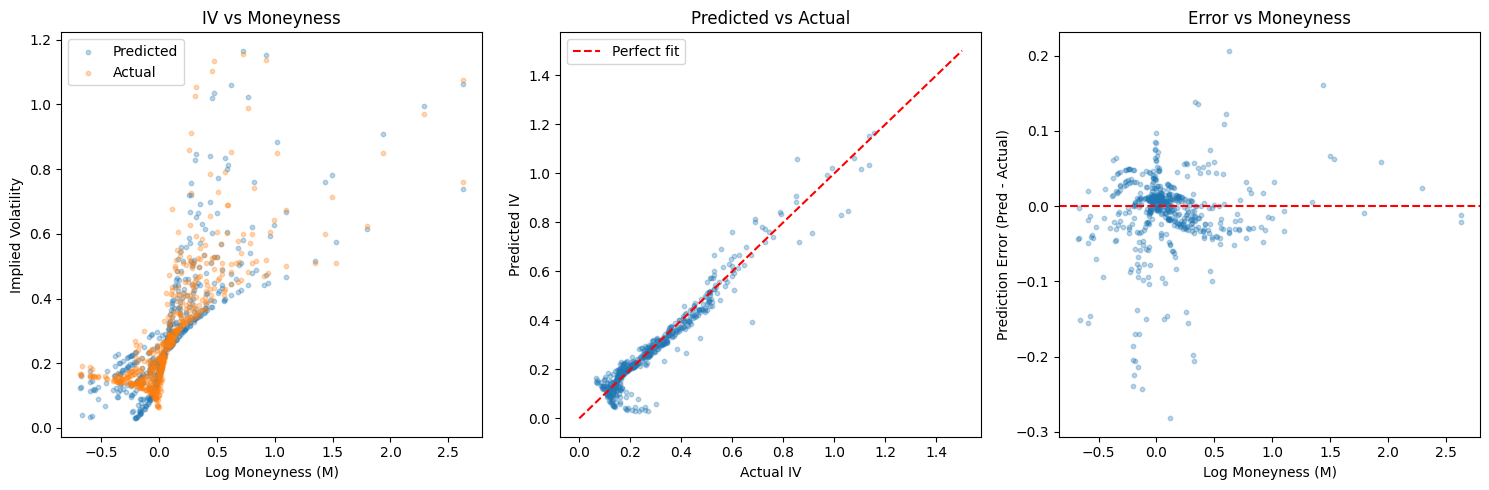

Saved: vol_surface_results.png


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

M_test_np = X_test[:, 0].numpy()
T_test_np = X_test[:, 1].numpy()

with torch.no_grad():
    pred_np = model_weighted(X_test).squeeze().numpy()
actual_np = y_test.numpy()

# Plot 1: Predicted IV vs Moneyness
ax1 = axes[0]
ax1.scatter(M_test_np, pred_np, alpha=0.3, s=10, label='Predicted')
ax1.scatter(M_test_np, actual_np, alpha=0.3, s=10, label='Actual')
ax1.set_xlabel('Log Moneyness (M)')
ax1.set_ylabel('Implied Volatility')
ax1.set_title('IV vs Moneyness')
ax1.legend()

# Plot 2: Predicted vs Actual (scatter)
ax2 = axes[1]
ax2.scatter(actual_np, pred_np, alpha=0.3, s=10)
ax2.plot([0, 1.5], [0, 1.5], 'r--', label='Perfect fit')
ax2.set_xlabel('Actual IV')
ax2.set_ylabel('Predicted IV')
ax2.set_title('Predicted vs Actual')
ax2.legend()

# Plot 3: Error by Moneyness
ax3 = axes[2]
error = pred_np - actual_np
ax3.scatter(M_test_np, error, alpha=0.3, s=10)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Log Moneyness (M)')
ax3.set_ylabel('Prediction Error (Pred - Actual)')
ax3.set_title('Error vs Moneyness')

plt.tight_layout()
plt.savefig('vol_surface_results.png', dpi=150)
plt.show()

print("Saved: vol_surface_results.png")

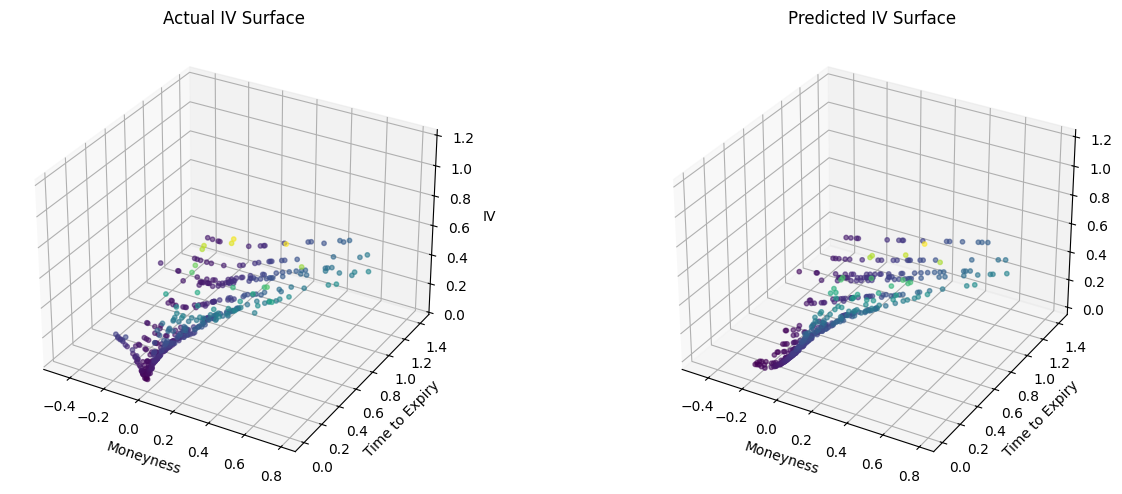

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 5))

# Filter for cleaner visualization (remove extreme moneyness)
mask = (M_test_np > -0.5) & (M_test_np < 0.8) & (T_test_np < 1.5)

M_plot = M_test_np[mask]
T_plot = T_test_np[mask]
pred_plot = pred_np[mask]
actual_plot = actual_np[mask]

# Plot 1: Actual surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(M_plot, T_plot, actual_plot, c=actual_plot, cmap='viridis', s=10, alpha=0.6)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Time to Expiry')
ax1.set_zlabel('IV')
ax1.set_title('Actual IV Surface')

# Plot 2: Predicted surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(M_plot, T_plot, pred_plot, c=pred_plot, cmap='viridis', s=10, alpha=0.6)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Time to Expiry')
ax2.set_zlabel('IV')
ax2.set_title('Predicted IV Surface')

plt.tight_layout()
plt.savefig('vol_surface_3d.png', dpi=150)
plt.show()

In [ ]:
# Proper calendar arbitrage check: same strike region, different expiry
# Group by narrow moneyness bands, then check variance across time

print("Calendar Arbitrage Check ")

M_test = X_test[:, 0]
T_test = X_test[:, 1]

with torch.no_grad():
    preds = model_weighted(X_test).squeeze()

# Narrow ATM band
atm_mask = torch.abs(M_test) < 0.05  # tighter band

M_atm = M_test[atm_mask]
T_atm = T_test[atm_mask]
iv_atm = y_test[atm_mask]

# Get unique expiries and average IV at each
unique_T = torch.unique(T_atm)
unique_T_sorted, _ = torch.sort(unique_T)


print(f"\n{'Expiry (T)':<12} {'Avg IV':<12} {'Total Var':<12}")

variances = []
for t in unique_T_sorted:
    mask = T_atm == t
    avg_iv = iv_atm[mask].mean().item()
    total_var = (avg_iv ** 2) * t.item()
    variances.append(total_var)
    print(f"{t.item():<12.4f} {avg_iv:<12.4f} {total_var:<12.6f}")

# Check for violations
variances = torch.tensor(variances)
diffs = variances[1:] - variances[:-1]
violations = (diffs < 0).sum().item()

Calendar Arbitrage Check (Proper)
Unique expiries in ATM band: 27

Expiry (T)   Avg IV       Total Var   
----------------------------------------
0.0055       0.1321       0.000096    
0.0082       0.1135       0.000106    
0.0110       0.1589       0.000277    
0.0137       0.1379       0.000260    
0.0219       0.1964       0.000845    
0.0329       0.1312       0.000566    
0.0521       0.1644       0.001406    
0.0712       0.1365       0.001328    
0.0904       0.1669       0.002519    
0.1096       0.1748       0.003347    
0.1671       0.1420       0.003370    
0.1973       0.1673       0.005521    
0.2438       0.1831       0.008171    
0.2795       0.1818       0.009240    
0.3589       0.1990       0.014214    
0.4137       0.1823       0.013750    
0.4466       0.1532       0.010475    
0.6658       0.1898       0.023978    
0.6986       0.2081       0.030260    
0.9151       0.2090       0.039972    
0.9507       0.2043       0.039692    
0.9918       0.2164       0.046463

In [ ]:
# Check the magnitude of real violations
print("Actual Calendar Violations:")
print("-" * 60)
print(f"{'T_short':<10} {'T_long':<10} {'Var_short':<12} {'Var_long':<12} {'Gap':<10}")
print("-" * 60)

T_list = unique_T_sorted.tolist()
var_list = variances.tolist()

for i in range(len(diffs)):
    if diffs[i] < 0:
        gap = abs(diffs[i].item())
        # Estimate profit: gap in variance terms
        # Rough conversion: gap * 100 = basis points
        print(f"{T_list[i]:<10.4f} {T_list[i+1]:<10.4f} {var_list[i]:<12.6f} {var_list[i+1]:<12.6f} {gap:<10.6f}")

print("-" * 60)
print("\nTransaction cost estimate: ~0.001 variance units")
print("Violations > 0.001 might be tradeable (before other costs)")

Actual Calendar Violations:
------------------------------------------------------------
T_short    T_long     Var_short    Var_long     Gap       
------------------------------------------------------------
0.0110     0.0137     0.000277     0.000260     0.000016  
0.0219     0.0329     0.000845     0.000566     0.000279  
0.0521     0.0712     0.001406     0.001328     0.000078  
0.3589     0.4137     0.014214     0.013750     0.000464  
0.4137     0.4466     0.013750     0.010475     0.003276  
0.9151     0.9507     0.039972     0.039692     0.000280  
1.1644     1.4110     0.066230     0.060517     0.005713  
------------------------------------------------------------

Transaction cost estimate: ~0.001 variance units
Violations > 0.001 might be tradeable (before other costs)


In [ ]:
import time

# single prediction
start = time.time()
for _ in range(10000):
    with torch.no_grad():
        pred = model_weighted(X_test[:1])
nn_time = time.time() - start

print(f"NN: 10,000 predictions in {nn_time:.4f} seconds")
print(f"Per prediction: {nn_time/10000*1000:.4f} ms")

NN: 10,000 predictions in 0.1612 seconds
Per prediction: 0.0161 ms


In [ ]:
# Delta = ∂Price/∂S, but we predict IV, so let's check ∂IV/∂M
X_test.requires_grad_(True)
pred = model_weighted(X_test)
pred.sum().backward()

delta_iv = X_test.grad[:, 0]  # ∂IV/∂M
print(f"Mean ∂IV/∂M: {delta_iv.mean():.4f}")
print(f"Stable (no NaN/Inf): {torch.isfinite(delta_iv).all()}")

Mean ∂IV/∂M: 0.7630
Stable (no NaN/Inf): True


# Market{Data} API Call 
	- Option Chain: 
		- GET https://api.marketdata.app/v1/options/chain/{underlyingSymbol}/
	- Spot Candles: 
		- GET https://api.marketdata.app/v1/stocks/candles/{resolution}/{symbol}/


In [5]:
chain_url = " https://api.marketdata.app/v1/options/chain/{underlyingSymbol}/"
candle_url = "https://api.marketdata.app/v1/stocks/candles/{resolution}/{symbol}/"


In [6]:
from pathlib import Path
import sys

# parent directory object
root = Path.cwd().parent
sys.path.append(str(root / "src")) 


In [1]:
from config import Settings
from data.fetch import MarketDataClient, ingest_bronze
from data.clean import run_clean_pipeline

ModuleNotFoundError: No module named 'config'

In [7]:
from config import Settings
import requests

In [8]:
s = Settings()
print(s.base_url)

https://api.marketdata.app/v1


#### Option Chain 

In [2]:
HEADERS = {"Authorization": f"Token {s.token}",   
           "Accept": "application/json"}

NameError: name 's' is not defined

In [10]:
# build url for option chain
def build_chain_url(base_url, symbol, expiration=None, side=None, date=None, columns=None):
    # query params 
    query_params = {
        "date": date, 
        "expiration": expiration,
        "side": side,
        "columns": columns
    }
    param_strings = []
    # filter none values 
    for k, v in query_params.items():
        if v is not None:
            item = f"{k}={v}"
            param_strings.append(item)
            
    # add & fro complete url 
    full_query = "&".join(param_strings)
    return f"{base_url}/options/chain/{symbol}/?{full_query}"

In [11]:
# post_url = build_chain_url(
#     s.base_url,
#     "AAPL",
#     s.token,
#     side="call",
#     expiration="2024-02-1",
#     date="2024-02-02"

# )
query_date = "2024-02-02"

post_url = build_chain_url(
    s.base_url, 
    "AAPL", 
    date=query_date,
    expiration="2024-02-16",
    side="call",
    columns="optionSymbol,expiration,strike,side,bid,ask,mid,dte"
)

print(post_url)

https://api.marketdata.app/v1/options/chain/AAPL/?date=2024-02-02&expiration=2024-02-16&side=call&columns=optionSymbol,expiration,strike,side,bid,ask,mid,dte


In [12]:
# requst using .get
r = requests.get(post_url, headers=HEADERS, timeout=120)
r.raise_for_status()
response_json = r.json()
print(response_json.keys())

# len check 
lengths = {k:len(v) for k, v in response_json.items() if isinstance(v,list)}
print(lengths)

dict_keys(['optionSymbol', 'expiration', 'strike', 'side', 'bid', 'ask', 'mid', 'dte'])
{'optionSymbol': 69, 'expiration': 69, 'strike': 69, 'side': 69, 'bid': 69, 'ask': 69, 'mid': 69, 'dte': 69}


In [13]:
data = response_json
option_chain_df = pd.DataFrame(data)
df = option_chain_df.copy()

# normalization 
df["T"] = df['dte'] / 365.0                                                 # annulaize the days to expiry
df["exp_date"] = pd.to_datetime(df["expiration"], unit="s", utc=True)       # exp_date to utc 
df["asoff_date"] = pd.to_datetime(query_date, utc=True).normalize()              # date object for the join on spot 
df

,optionSymbol,expiration,strike,side,bid,ask,mid,dte,T,exp_date,asoff_date
0,AAPL240216C00050000,1708117200,50.0,call,135.50,136.30,135.900,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
1,AAPL240216C00055000,1708117200,55.0,call,130.45,131.30,130.875,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
2,AAPL240216C00060000,1708117200,60.0,call,125.45,126.30,125.875,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
3,AAPL240216C00065000,1708117200,65.0,call,120.50,121.35,120.925,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
4,AAPL240216C00070000,1708117200,70.0,call,115.10,116.35,115.725,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...
64,AAPL240216C00300000,1708117200,300.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
65,AAPL240216C00305000,1708117200,305.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
66,AAPL240216C00310000,1708117200,310.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00
67,AAPL240216C00315000,1708117200,315.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00


#### Spot 

In [14]:
# spot url
def build_spot_url(base_url, resolution, symbol, date=None, columns=None):
    # query params 
    query_params = {
        "date": date, 
        "columns": columns,
    }
    param_strings = []
    # filter none values 
    for k, v in query_params.items():
        if v is not None:
            item = f"{k}={v}"
            param_strings.append(item)
    full_query = "&".join(param_strings)
    return f"{base_url}//stocks/candles/{resolution}/{symbol}/?{full_query}"

In [15]:
# build url for spot 
spot_url = build_spot_url(
    s.base_url, 
    "D",
    "VIXY", 
    date=query_date,
    columns="s, o, c, t"
    )

# request 
req = requests.get(spot_url, headers=HEADERS, timeout=60)
req.raise_for_status()
req_json = req.json()
print(req_json.keys())

# len check 
length = {k:len(v) for k, v in req_json.items() if isinstance(v, list)} 
print(length)

dict_keys(['s', 'o', 'c', 't'])
{'o': 1, 'c': 1, 't': 1}


In [16]:
spot_df = pd.DataFrame(req_json)
spot_df = spot_df.rename(columns={"S": "Status", "c" : "S", "t":"Date"})
spot_df["Date"] = pd.to_datetime(spot_df["Date"], unit="s", utc=True)
spot_df["asoff_date"] = pd.to_datetime(query_date, utc=True).normalize()
spot_df

,s,o,S,Date,asoff_date
0,ok,59.48,59.6,2024-02-02 05:00:00+00:00,2024-02-02 00:00:00+00:00


In [17]:
# merge as_off for the spot and option chain 
merged = df.merge(
    spot_df[['asoff_date', "S"]],
    on="asoff_date",
    how="left"
) 

merged

,optionSymbol,expiration,strike,side,bid,ask,mid,dte,T,exp_date,asoff_date,S
0,AAPL240216C00050000,1708117200,50.0,call,135.50,136.30,135.900,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
1,AAPL240216C00055000,1708117200,55.0,call,130.45,131.30,130.875,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
2,AAPL240216C00060000,1708117200,60.0,call,125.45,126.30,125.875,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
3,AAPL240216C00065000,1708117200,65.0,call,120.50,121.35,120.925,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
4,AAPL240216C00070000,1708117200,70.0,call,115.10,116.35,115.725,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
...,...,...,...,...,...,...,...,...,...,...,...,...
64,AAPL240216C00300000,1708117200,300.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
65,AAPL240216C00305000,1708117200,305.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
66,AAPL240216C00310000,1708117200,310.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6
67,AAPL240216C00315000,1708117200,315.0,call,0.00,0.01,0.005,14,0.038356,2024-02-16 21:00:00+00:00,2024-02-02 00:00:00+00:00,59.6


In [18]:
merged["K"] = merged["strike"]
merged["V"] = merged["mid"]
merged["logM"] = np.log(merged["S"] / merged["K"])

#### Option Quotes 

In [19]:
def build_quote_url(base_url, optionSymbol, expiration=None, side=None, date=None, columns=None):
    # query params 
    query_params = {
        "date": date, 
        "expiration": expiration,
        "side": side,
        "columns": columns, 
    }
    
    
    # filter none values 
    param_strings = []
    for k, v in query_params.items():
        if v is not None:
            item = f"{k}={v}"
            param_strings.append(item)
            
                     
    # add & fro complete url 
    full_query = "&".join(param_strings)
    return f"{base_url}/options/quotes/{optionSymbol}/?{full_query}"

In [20]:
opSymb = df["optionSymbol"].iloc[0] 
post_quote_url = build_quote_url(
    s.base_url, 
    opSymb, 
    date=query_date,
    side="call"
    )

print(post_quote_url)

https://api.marketdata.app/v1/options/quotes/AAPL240216C00050000/?date=2024-02-02&side=call


In [21]:
r = requests.get(post_quote_url, headers=HEADERS, timeout=120)
r.raise_for_status()
response_json = r.json()
print(response_json.keys())


# len check 
lengths = {k:len(v) for k, v in response_json.items() if isinstance(v,list)}
print(lengths)
response_json

dict_keys(['s', 'optionSymbol', 'underlying', 'expiration', 'side', 'strike', 'firstTraded', 'dte', 'updated', 'bid', 'bidSize', 'mid', 'ask', 'askSize', 'last', 'openInterest', 'volume', 'inTheMoney', 'intrinsicValue', 'extrinsicValue', 'underlyingPrice', 'iv', 'delta', 'gamma', 'theta', 'vega'])
{'optionSymbol': 1, 'underlying': 1, 'expiration': 1, 'side': 1, 'strike': 1, 'firstTraded': 1, 'dte': 1, 'updated': 1, 'bid': 1, 'bidSize': 1, 'mid': 1, 'ask': 1, 'askSize': 1, 'last': 1, 'openInterest': 1, 'volume': 1, 'inTheMoney': 1, 'intrinsicValue': 1, 'extrinsicValue': 1, 'underlyingPrice': 1, 'iv': 1, 'delta': 1, 'gamma': 1, 'theta': 1, 'vega': 1}


{'s': 'ok',
 'optionSymbol': ['AAPL240216C00050000'],
 'underlying': ['AAPL'],
 'expiration': [1708117200],
 'side': ['call'],
 'strike': [50],
 'firstTraded': [1692279000],
 'dte': [14],
 'updated': [1706907600],
 'bid': [135.5],
 'bidSize': [50],
 'mid': [135.9],
 'ask': [136.3],
 'askSize': [54],
 'last': [135.1],
 'openInterest': [29],
 'volume': [0],
 'inTheMoney': [True],
 'intrinsicValue': [135.85],
 'extrinsicValue': [0.05],
 'underlyingPrice': [185.85],
 'iv': [None],
 'delta': [None],
 'gamma': [None],
 'theta': [None],
 'vega': [None]}

________________

#### loop for dates

In [22]:
import time 
import os 
import json

In [23]:
# loop through all the days to get data 
start_date = "2025-01-01" 
end_date = "2026-01-03"  

trading_days = pd.date_range(start=start_date, end=end_date, freq='B') # for 250 business days 

In [63]:
all_frames = []

for day in trading_days:
    query_date = day.strftime('%Y-%m-%d')
    file_path = root / f"data/spy_option/raw/spy_{query_date}.json"
    
    # avoid re-fetch 
    if file_path.exists():
        print(f"skipping {query_date}: File Exists in Raw")
        continue
    
    try:
        # fetch option chain 
        chain_url = build_chain_url(s.base_url, "SPY", date=query_date, side="call")
        r_chain = requests.get(chain_url, headers=HEADERS, timeout=30)
        
        # market closed date 
        if r_chain.status_code == 404:
            print(f"no chain data for {query_date}  likely holiday; skipping")
            continue
    
        # save json     
        r_chain.raise_for_status()
        chain_raw = r_chain.json()
        
        spot_url = build_spot_url(s.base_url, "D", "SPY", date=query_date)
        r_spot = requests.get(spot_url, headers=HEADERS, timeout=30)
        r_spot.raise_for_status()
        spot_raw = r_spot.json()
        
        raw_payload = {
            "snapshot_date": query_date,
            "chain": chain_raw,
            "spot": spot_raw
        }
        
        file_path.parent.mkdir(parents=True, exist_ok=True)
        with open(file_path, "w") as f:
            json.dump(raw_payload, f)
        
            
        print(f"Bronze Ingested: {query_date}")
        time.sleep(2)
        
    except Exception as e:
        print(f"ingestion failed for {query_date}: {e}")
        

no chain data for 2025-01-01  likely holiday; skipping
skipping 2025-01-02: File Exists in Raw
skipping 2025-01-03: File Exists in Raw


In [24]:
PROCESSED_DIR = root / "data" / "spy_option" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [25]:
RAW = root / "data" / "spy_option" / "raw"

In [26]:
import glob

cleaned_data = []
bronze_files = list(RAW.glob("*.json"))                 # glob to list all the files in the raw folder

for path in bronze_files:                               
    with open(path, "r") as f:                           # read mode open files  
        raw = json.load(f)       
        # Process 
        # create  df 
        df = pd.DataFrame(raw.get("chain", {}))

        # add date 
        df["snapshot_date"] = raw.get("snapshot_date")
        
        # get the stock price 
        stock_price = raw.get("spot", {}).get("c")
        df["spot_price"] = stock_price[0] if isinstance(stock_price, list) else stock_price
        
        # save 
        cleaned_data.append(df)
        
        
final_df = pd.concat(cleaned_data, ignore_index=True) 

In [29]:
final_df

,s,optionSymbol,underlying,expiration,side,strike,firstTraded,dte,updated,bid,...,intrinsicValue,extrinsicValue,underlyingPrice,iv,delta,gamma,theta,vega,snapshot_date,spot_price
0,ok,SPY250516C00285000,SPY,1747426500,call,285,1744119000,4,1747080000,297.30,...,297.99,0.395,582.99,None,None,None,None,None,2025-05-12,582.99
1,ok,SPY250516C00290000,SPY,1747426500,call,290,1744119000,4,1747080000,292.28,...,292.99,0.380,582.99,None,None,None,None,None,2025-05-12,582.99
2,ok,SPY250516C00295000,SPY,1747426500,call,295,1744119000,4,1747080000,287.31,...,287.99,0.400,582.99,None,None,None,None,None,2025-05-12,582.99
3,ok,SPY250516C00300000,SPY,1747426500,call,300,1744119000,4,1747080000,282.87,...,282.99,0.700,582.99,None,None,None,None,None,2025-05-12,582.99
4,ok,SPY250516C00305000,SPY,1747426500,call,305,1734705000,4,1747080000,277.31,...,277.99,0.400,582.99,None,None,None,None,None,2025-05-12,582.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52643,ok,SPY250417C00810000,SPY,1744920900,call,810,1719408600,7,1744315200,0.00,...,0.00,0.005,524.58,None,None,None,None,None,2025-04-10,524.58
52644,ok,SPY250417C00815000,SPY,1744920900,call,815,1721395800,7,1744315200,0.00,...,0.00,0.005,524.58,None,None,None,None,None,2025-04-10,524.58
52645,ok,SPY250417C00820000,SPY,1744920900,call,820,1721395800,7,1744315200,0.00,...,0.00,0.005,524.58,None,None,None,None,None,2025-04-10,524.58
52646,ok,SPY250417C00825000,SPY,1744920900,call,825,1721395800,7,1744315200,0.00,...,0.00,0.005,524.58,None,None,None,None,None,2025-04-10,524.58


In [30]:
final_df['optionSymbol'].nunique()

4821

In [31]:
final_df.groupby("optionSymbol")["snapshot_date"].nunique().describe()

count    4821.000000
mean       10.920556
std         4.814367
min         1.000000
25%         8.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: snapshot_date, dtype: float64

In [32]:
# No duplicate contract/day
assert not final_df.duplicated(["optionSymbol", "snapshot_date"]).any()

# Daily contract counts are stable
final_df.groupby("snapshot_date")["optionSymbol"].nunique().describe()


count    213.000000
mean     247.173709
std       48.863430
min      176.000000
25%      205.000000
50%      251.000000
75%      266.000000
max      383.000000
Name: optionSymbol, dtype: float64

In [33]:
print("rows:", len(df))
print("unique dates:", df["snapshot_date"].nunique())
print("unique optionSymbols:", df["optionSymbol"].nunique())

rows: 383
unique dates: 1
unique optionSymbols: 383


In [34]:
symb = "SPY250516C00285000"

final_df[final_df["optionSymbol"] == symb][["snapshot_date", "spot_price", "mid"]].sort_values("snapshot_date")

,snapshot_date,spot_price,mid
34312,2025-05-01,558.47,272.165
17804,2025-05-02,566.76,282.455
11953,2025-05-05,563.51,278.410
41101,2025-05-06,558.80,274.070
50810,2025-05-07,561.15,276.970
4532,2025-05-08,565.06,280.720
7792,2025-05-09,564.34,279.715
0,2025-05-12,582.99,298.385
13351,2025-05-13,586.84,301.760
16551,2025-05-14,587.59,302.545


In [35]:
final_df.columns

Index(['s', 'optionSymbol', 'underlying', 'expiration', 'side', 'strike',
       'firstTraded', 'dte', 'updated', 'bid', 'bidSize', 'mid', 'ask',
       'askSize', 'last', 'openInterest', 'volume', 'inTheMoney',
       'intrinsicValue', 'extrinsicValue', 'underlyingPrice', 'iv', 'delta',
       'gamma', 'theta', 'vega', 'snapshot_date', 'spot_price'],
      dtype='object')

In [ ]:
new_df = final_df[["optionSymbol", "expiration", "dte", "intrinsicValue", "extrinsicValue", "strike", "mid", "underlyingPrice", "spot_price", "snapshot_date", "volume", "inTheMoney"]].copy()
new_df["snapshot_date"] = pd.to_datetime(new_df["snapshot_date"])
new_df["snapshot_date"].sort_values()
new_df["t_ann"] = new_df["dte"] / 252
new_df["t_ann"].describe()
new_df["M"] = np.log(new_df["underlyingPrice"] / new_df["strike"])
new_df["M"].describe()

count    52648.000000
mean         0.135525
std          0.300213
min         -0.565164
25%         -0.031610
50%          0.069242
75%          0.229892
max          2.623465
Name: M, dtype: float64

In [60]:
# vix from the yfinance, an approximate proxy but workable as we are comparing the two models with the same inputs 
vix = yf.download("^VIX", start="2024-12-30", end="2026-02-02")["Close"] / 100
vix = vix.shift(1)  # lag 

[*********************100%***********************]  1 of 1 completed


In [61]:
vix = vix.reset_index().rename(columns={"Date": "snapshot_date", "^VIX": "VIX"})
vix.to_csv(r"root\data\spy_option\processed\vix.csv", index=False)

In [62]:
# merge the vix on option chain data using snapshot_date
merged = pd.merge(new_df,
                  vix,
                  on="snapshot_date",
                  how="left"
)

merged

,optionSymbol,expiration,dte,intrinsicValue,extrinsicValue,strike,mid,underlyingPrice,spot_price,snapshot_date,volume,inTheMoney,t_ann,M,VIX
0,SPY250516C00285000,1747426500,4,297.99,0.395,285,298.385,582.99,582.99,2025-05-12,0,True,0.010959,0.715681,0.2190
1,SPY250516C00290000,1747426500,4,292.99,0.380,290,293.370,582.99,582.99,2025-05-12,0,True,0.010959,0.698289,0.2190
2,SPY250516C00295000,1747426500,4,287.99,0.400,295,288.390,582.99,582.99,2025-05-12,0,True,0.010959,0.681195,0.2190
3,SPY250516C00300000,1747426500,4,282.99,0.700,300,283.690,582.99,582.99,2025-05-12,1,True,0.010959,0.664388,0.2190
4,SPY250516C00305000,1747426500,4,277.99,0.400,305,278.390,582.99,582.99,2025-05-12,0,True,0.010959,0.647858,0.2190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52643,SPY250417C00810000,1744920900,7,0.00,0.005,810,0.005,524.58,524.58,2025-04-10,0,False,0.019178,-0.434436,0.3362
52644,SPY250417C00815000,1744920900,7,0.00,0.005,815,0.005,524.58,524.58,2025-04-10,0,False,0.019178,-0.440590,0.3362
52645,SPY250417C00820000,1744920900,7,0.00,0.005,820,0.005,524.58,524.58,2025-04-10,0,False,0.019178,-0.446706,0.3362
52646,SPY250417C00825000,1744920900,7,0.00,0.005,825,0.005,524.58,524.58,2025-04-10,0,False,0.019178,-0.452785,0.3362


In [63]:
merged["strike"] = merged["strike"].astype(float)
merged["mid"] = merged["mid"].astype(float)
merged["t_ann"] = merged["t_ann"].astype(float)
merged["M"] = merged["M"].astype(float)
merged["VIX"] = merged["VIX"].astype(float)

In [64]:
n_bad = (merged["t_ann"] <= 0)
print(f"Dropping {n_bad.sum()} contracts with non-positive maturity")
# filter the contracts
merged = merged[merged["t_ann"] > 0].copy()                # time to maturity must be greater than 0

# check for the nan and inf in the moneyness, time to maturity and VIX 
selected_cols = merged[["M", "t_ann", "VIX"]]
bad_mask = ~np.isfinite(selected_cols).all(axis=1)          # for all rows in the selected colums 
print("Bad rows:", bad_mask.sum())

for c in selected_cols:
    n_nan = merged[c].isna().sum()
    n_inf = np.isinf(merged[c]).sum()
    print(f"{c}: NaN={n_nan}, Inf={n_inf}, Nonfinite={(~np.isfinite(merged[c])).sum()}")

# remove nans and infs 
merged = merged[~bad_mask]

Dropping 4435 contracts with non-positive maturity
Bad rows: 190
M: NaN=0, Inf=0, Nonfinite=0
t_ann: NaN=0, Inf=0, Nonfinite=0
VIX: NaN=190, Inf=0, Nonfinite=190


In [65]:
for c in selected_cols:
    n_nan = merged[c].isna().sum()
    n_inf = np.isinf(merged[c]).sum()
    print(f"{c}: NaN={n_nan}, Inf={n_inf}, Nonfinite={(~np.isfinite(merged[c])).sum()}")

M: NaN=0, Inf=0, Nonfinite=0
t_ann: NaN=0, Inf=0, Nonfinite=0
VIX: NaN=0, Inf=0, Nonfinite=0


### assert for the following conditions 
1. only positive time to maturity 
2. no nans and infs for the inputs 
3. strike must be strictly positive
4. mid must be postive 

In [66]:
assert (merged["t_ann"] > 0).all()
assert np.isfinite(merged[["M", "t_ann", "VIX"]]).all().all(), "NaNs or infs in X"
assert (merged["strike"] > 0).all(), "Invalid strikes"
assert (merged["mid"] >= 0).all(), "Negative prices"

In [82]:
# target variable 
merged["C/K"] = merged["mid"] / merged["strike"]
merged["C"] = merged["mid"]

# input variables
X = merged[["t_ann", "M", "VIX"]].to_numpy(dtype=np.float32)
merged.to_csv("market_data.csv")

In [71]:
merged[["t_ann", "C/K", "VIX", "M"]].describe()

,t_ann,C/K,VIX,M
count,48023.000000,48023.000000,48023.000000,48023.000000
mean,0.024253,0.249532,0.192794,0.135883
std,0.016627,0.572505,0.064271,0.302292
min,0.002740,0.000004,0.134700,-0.565164
25%,0.008219,0.000398,0.157900,-0.031832
50%,0.021918,0.073545,0.169300,0.068865
75%,0.038356,0.260385,0.202800,0.230291
max,0.068493,12.784900,0.523300,2.623465


#### yfinance DATA Check 

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

def get_vix_vol():
    vix = yf.Ticker("^VIX")
    vix_level = float(vix.history(period="1d")["Close"].iloc[-1])
    return vix_level / 100.0

def get_realized_vol_30d():
    spy = yf.Ticker("SPY")
    hist = spy.history(period="90d")  # buffer
    rets = np.log(hist["Close"] / hist["Close"].shift(1)).dropna()
    rv = rets.tail(30).std() * np.sqrt(252)
    return float(rv)

def atm_term_vol(df, atm_band=0.03):
    """
    Build a per-expiry ATM vol curve, then map each option to its expiry's ATM vol.
    Requires df['expiry'] and some iv column if you want to use it.
    Here we use yfinance impliedVolatility ONLY to estimate ATM term vol,
    then apply flat-across-strikes for that expiry (non-circular across strikes).
    """
    if "impliedVolatility" not in df.columns:
        raise ValueError("Need impliedVolatility column to estimate ATM term vol.")
    atm = df[np.abs(df["M"]) < atm_band].copy()
    if len(atm) < 10:
        raise ValueError("Too few ATM options to estimate term vol.")
    term = atm.groupby("expiry")["impliedVolatility"].mean()
    return df["expiry"].map(term).astype(float)

# attach proxies
df = df_real.copy()

df["sigma_vix"] = get_vix_vol()
df["sigma_rv30"] = get_realized_vol_30d()
df["sigma_atm_term"] = atm_term_vol(df, atm_band=0.03)

print("VIX vol:", df["sigma_vix"].iloc[0])
print("RV30 vol:", df["sigma_rv30"].iloc[0])
print("ATM-term vol range:", df["sigma_atm_term"].min(), df["sigma_atm_term"].max())

NameError: name 'df_real' is not defined

In [ ]:
import torch

@torch.no_grad()
def predict_ck_with_sigma(model, df, sigma_col):
    X = np.column_stack([
        df["M"].astype(float).values,
        df["T"].astype(float).values,
        df[sigma_col].astype(float).values
    ]).astype(np.float32)
    X_t = torch.tensor(X, dtype=torch.float32)
    return model(X_t).squeeze().cpu().numpy()

def add_proxy_predictions(df, model_mse, model_wmse, sigma_col):
    out = df.copy()
    out["mkt_ck"] = (out["mid"] / out["strike"].astype(float)).astype(float)  # market normalized

    out[f"mse_ck_{sigma_col}"] = predict_ck_with_sigma(model_mse, out, sigma_col)
    out[f"wmse_ck_{sigma_col}"] = predict_ck_with_sigma(model_wmse, out, sigma_col)

    # dollars (optional)
    K = out["strike"].astype(float).values
    out[f"mse_${sigma_col}"]  = K * out[f"mse_ck_{sigma_col}"]
    out[f"wmse_${sigma_col}"] = K * out[f"wmse_ck_{sigma_col}"]
    return out


In [ ]:
def rmse(a, b):
    e = np.asarray(a) - np.asarray(b)
    return float(np.sqrt(np.mean(e * e)))

def mae(a, b):
    e = np.asarray(a) - np.asarray(b)
    return float(np.mean(np.abs(e)))

def slice_masks(df, atm_band=0.10, short_days=30):
    short_T = short_days / 365.0
    M = df["M"].values
    T = df["T"].values
    return {
        "ALL": np.ones(len(df), dtype=bool),
        "ATM": np.abs(M) < atm_band,
        "SHORT": T < short_T,
        "ATM_x_SHORT": (np.abs(M) < atm_band) & (T < short_T),
    }

def market_metrics(df, mse_col, wmse_col, target_col="mkt_ck"):
    masks = slice_masks(df)
    rows = []
    for name, mask in masks.items():
        d = df.loc[mask]
        if len(d) == 0:
            continue
        rows.append({
            "slice": name,
            "n": int(len(d)),
            "MSE vs MKT (C/K) RMSE": rmse(d[mse_col], d[target_col]),
            "WMSE vs MKT (C/K) RMSE": rmse(d[wmse_col], d[target_col]),
            "MSE vs MKT (C/K) MAE": mae(d[mse_col], d[target_col]),
            "WMSE vs MKT (C/K) MAE": mae(d[wmse_col], d[target_col]),
        })
    return pd.DataFrame(rows)


In [ ]:
results = []

for sigma_col in ["sigma_vix", "sigma_rv30", "sigma_atm_term"]:
    dfp = add_proxy_predictions(df, model_mse, model_wmse, sigma_col)
    tab = market_metrics(
        dfp,
        mse_col=f"mse_ck_{sigma_col}",
        wmse_col=f"wmse_ck_{sigma_col}",
        target_col="mkt_ck"
    )
    tab.insert(0, "vol_proxy", sigma_col)
    results.append(tab)

final_market_table = pd.concat(results, ignore_index=True)
display(final_market_table)


,vol_proxy,slice,n,MSE vs MKT (C/K) RMSE,WMSE vs MKT (C/K) RMSE,MSE vs MKT (C/K) MAE,WMSE vs MKT (C/K) MAE
0,sigma_vix,ALL,1003,0.085979,0.073896,0.081157,0.069414
1,sigma_vix,ATM,774,0.095365,0.082288,0.094878,0.081738
2,sigma_vix,SHORT,901,0.086550,0.074415,0.081816,0.069978
3,sigma_vix,ATM_x_SHORT,695,0.095962,0.082848,0.095476,0.082298
4,sigma_rv30,ALL,1003,0.084799,0.074173,0.080012,0.069646
5,sigma_rv30,ATM,774,0.094076,0.082597,0.093576,0.082042
6,sigma_rv30,SHORT,901,0.085419,0.074754,0.080719,0.070274
7,sigma_rv30,ATM_x_SHORT,695,0.094729,0.083227,0.094233,0.082676
8,sigma_atm_term,ALL,1003,0.085868,0.073901,0.081037,0.069414
9,sigma_atm_term,ATM,774,0.095249,0.082295,0.094752,0.081745


In [ ]:
def detailed_moneyness_analysis(df, mse_col, wmse_col, target_col="mkt_ck"):
    """Break down by granular moneyness bins"""
    
    # Define bins
    bins = [
        ("Deep ITM", lambda m: m < -0.3),
        ("ITM", lambda m: (m >= -0.3) & (m < -0.1)),
        ("ATM", lambda m: (m >= -0.1) & (m < 0.1)),
        ("OTM", lambda m: (m >= 0.1) & (m < 0.3)),
        ("Deep OTM", lambda m: m >= 0.3),
    ]
    
    rows = []
    for name, condition in bins:
        mask = condition(df["M"].values)
        d = df.loc[mask]
        if len(d) < 10:  # Skip sparse bins
            continue
            
        mse_rmse = rmse(d[mse_col], d[target_col])
        wmse_rmse = rmse(d[wmse_col], d[target_col])
        
        rows.append({
            "Region": name,
            "n": len(d),
            "MSE RMSE": f"{mse_rmse:.4f}",
            "WMSE RMSE": f"{wmse_rmse:.4f}",
            "WMSE/MSE Ratio": f"{wmse_rmse/mse_rmse:.3f}",  # <1.0 means WMSE better
            "Improvement": f"{100*(1-wmse_rmse/mse_rmse):.1f}%"
        })
    
    return pd.DataFrame(rows)

# Run for each vol proxy
print("\n=== VIX Vol Proxy ===")
dfp_vix = add_proxy_predictions(df, model_mse, model_wmse, "sigma_vix")
display(detailed_moneyness_analysis(dfp_vix, "mse_ck_sigma_vix", "wmse_ck_sigma_vix"))

print("\n=== RV30 Vol Proxy ===")
dfp_rv = add_proxy_predictions(df, model_mse, model_wmse, "sigma_rv30")
display(detailed_moneyness_analysis(dfp_rv, "mse_ck_sigma_rv30", "wmse_ck_sigma_rv30"))


=== VIX Vol Proxy ===


,Region,n,MSE RMSE,WMSE RMSE,WMSE/MSE Ratio,Improvement
0,ATM,774,0.0954,0.0823,0.863,13.7%
1,OTM,171,0.0433,0.0330,0.762,23.8%
2,Deep OTM,57,0.0298,0.0287,0.962,3.8%



=== RV30 Vol Proxy ===


,Region,n,MSE RMSE,WMSE RMSE,WMSE/MSE Ratio,Improvement
0,ATM,774,0.0941,0.0826,0.878,12.2%
1,OTM,171,0.0425,0.0336,0.791,20.9%
2,Deep OTM,57,0.0295,0.0272,0.921,7.9%


______________